In [ ]:
!git clone https://github.com/TheMrGhostman/Semi-supervised-Learning-with-VAE.git

In [ ]:
import os 
os.chdir("Semi-supervised-Learning-with-VAE/")

In [16]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from utils.inference import SVI
import utils.models as m
import utils.datasets as d
from utils.layers import *

# Create Model


In [17]:
class LSTM_Encoder(nn.Module):
    def __init__(self, sequence_len, n_features, hidden_size, num_layers, latent_dim):
        super(LSTM_Encoder, self).__init__()
        self.encoder_reshape = Reshape(out_shape=(sequence_len, n_features))
        self.encoder_lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers) 
        self.encoder_output = VariationalLayer(
            in_features=hidden_size*2, 
            out_features=latent_dim, 
            return_KL=False
        )

    def forward(self, x_in):
        x = self.encoder_reshape(x_in)
        #set_trace()
        x = x.permute(1, 0, 2)
        _,(h_end, c_end) = self.encoder_lstm(x)
        h_end = h_end[-1, :, :] # "-1" means last hidden layer ; shape(batch_size, num_features)
        c_end = c_end[-1, :, :]
        long_short_memory = torch.cat((h_end, c_end), axis=1)
        return self.encoder_output(long_short_memory)

In [18]:
class LSTM_Decoder(nn.Module):
    def __init__(self, sequence_len, n_features, hidden_size, num_layers, latent_dim):
        super(LSTM_Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.decoder_hidden = nn.Linear(
            in_features=latent_dim,
            out_features=hidden_size*2,
            bias=True	
        )
        self.decoder_lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=False,
            bidirectional=False
        ) 
        self.decoder_output = RecurrentDecoderOutput(
            in_features=hidden_size,
            sequence_len=sequence_len,
            out_features=n_features,
            bias=True
        )

    def forward(self, h_in, decoder_input):
        h_state = self.decoder_hidden(h_in)
        #set_trace()

        h_0 = h_state[:, :self.hidden_size]
        c_0 = h_state[:, self.hidden_size:]

        h_0 = torch.stack([h_0 for _ in range(self.num_layers)])
        c_0 = torch.stack([c_0 for _ in range(self.num_layers)])

        lstm_output, _ = self.decoder_lstm(decoder_input, (h_0, c_0))
        mu, sigma = self.decoder_output(lstm_output)
        return mu, sigma

In [19]:
class LSTM_VAE(nn.Module):
    def __init__(self, sequence_len, n_features, latent_dim, hidden_size=128, num_layer=2, use_cuda=True):
        super(LSTM_VAE, self).__init__()

        self.encoder = LSTM_Encoder(sequence_len, n_features, hidden_size, num_layer, latent_dim)
        self.decoder = LSTM_Decoder(sequence_len, n_features, hidden_size, num_layer, latent_dim)

        if use_cuda and torch.cuda.is_available():
            self.dtype = torch.cuda.FloatTensor
            self.cuda()
        else:
            self.dtype = torch.float32


    def forward(self, x_in):
        z, mu, sigma = self.encoder(x_in)
        decoder_input = torch.zeros_like(x_in).type(self.dtype)
        decoder_input = self.encoder.encoder_reshape(decoder_input).permute(1,0,2)
        return self.decoder(z, decoder_input), mu, sigma


# data

In [20]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [21]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [22]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
train = d.H_alphaSequences(X_train, y_train)
test = d.H_alphaSequences(X_test, y_test)

In [24]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size=200, shuffle=True)

# Model Definition

In [11]:
vae = LSTM_VAE(sequence_len=160, n_features=1, latent_dim=15, hidden_size=128, num_layer=1, use_cuda=True)

In [12]:
optim = torch.optim.Adam(vae.parameters(), lr=1e-3)

svi = SVI(
        vae_model=vae,
        optimizer=optim,
        scheduler=torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[150], gamma=0.1),
        loss_function="GaussianNLL",
        tensorboard=True,
        model_name="LSTM_VAE_NLL_500ep_hidden-128_lr-{1e-3,1e-4}_bs-300",
        verbose=True
        )

cuda:0


In [ ]:
loss_hist = svi(epochs=300, train_loader=train_loader, validation_loader=test_loader)

Epoch [1/300], average_loss:210.5194, validation_loss:207.3593
Epoch [2/300], average_loss:223.0296, validation_loss:212.5129
Epoch [3/300], average_loss:209.9466, validation_loss:208.8548
Epoch [4/300], average_loss:209.7614, validation_loss:208.7356
Epoch [5/300], average_loss:209.7291, validation_loss:209.5001
Epoch [6/300], average_loss:209.3883, validation_loss:209.9100
Epoch [7/300], average_loss:187.6957, validation_loss:170.1603
Epoch [8/300], average_loss:163.4904, validation_loss:164.2904
Epoch [9/300], average_loss:161.7094, validation_loss:155.6118
Epoch [10/300], average_loss:162.0713, validation_loss:163.6447
Epoch [11/300], average_loss:159.3165, validation_loss:156.1895
Epoch [12/300], average_loss:158.1055, validation_loss:155.0660
Epoch [13/300], average_loss:163.8836, validation_loss:160.0628
Epoch [14/300], average_loss:158.2574, validation_loss:155.1109
Epoch [15/300], average_loss:160.1393, validation_loss:156.8309
Epoch [16/300], average_loss:166.5068, validation

Epoch [130/300], average_loss:-94.8146, validation_loss:-59.9452
Epoch [131/300], average_loss:-93.7058, validation_loss:-81.7771
Epoch [132/300], average_loss:-102.1307, validation_loss:-105.5418
Epoch [133/300], average_loss:-97.0068, validation_loss:-86.6120
Epoch [134/300], average_loss:-93.0803, validation_loss:-97.9076
Epoch [135/300], average_loss:-87.6538, validation_loss:-103.4775
Epoch [136/300], average_loss:-93.1641, validation_loss:-114.3388
Epoch [137/300], average_loss:-95.8419, validation_loss:-90.3045
Epoch [138/300], average_loss:-100.7355, validation_loss:-77.9521
Epoch [139/300], average_loss:-94.4774, validation_loss:-70.3454
Epoch [140/300], average_loss:-102.3062, validation_loss:-117.2046
Epoch [141/300], average_loss:-110.5262, validation_loss:-109.4993
Epoch [142/300], average_loss:-86.2587, validation_loss:-104.2268
Epoch [143/300], average_loss:-102.5005, validation_loss:-115.4732
Epoch [144/300], average_loss:-103.6789, validation_loss:-113.3361
Epoch [145/

In [25]:
loss_hist = svi(epochs=range(238,400), train_loader=train_loader, validation_loader=test_loader)

Epoch [239/400], average_loss:-151.4724, validation_loss:-147.9083
Epoch [240/400], average_loss:-152.0568, validation_loss:-148.9757
Epoch [241/400], average_loss:-152.3038, validation_loss:-148.5622
Epoch [242/400], average_loss:-152.3504, validation_loss:-148.9025
Epoch [243/400], average_loss:-151.8285, validation_loss:-147.3438
Epoch [244/400], average_loss:-151.7957, validation_loss:-149.5350
Epoch [245/400], average_loss:-152.3801, validation_loss:-147.9211
Epoch [246/400], average_loss:-152.3629, validation_loss:-148.3435
Epoch [247/400], average_loss:-152.7093, validation_loss:-147.3124
Epoch [248/400], average_loss:-152.2790, validation_loss:-149.5382
Epoch [249/400], average_loss:-152.9670, validation_loss:-149.4081
Epoch [250/400], average_loss:-152.9216, validation_loss:-148.9545
Epoch [251/400], average_loss:-152.1534, validation_loss:-149.6456
Epoch [252/400], average_loss:-153.3496, validation_loss:-149.6437
Epoch [253/400], average_loss:-153.1823, validation_loss:-148.

Epoch [362/400], average_loss:-158.0861, validation_loss:-154.2872
Epoch [363/400], average_loss:-158.5441, validation_loss:-154.6863
Epoch [364/400], average_loss:-157.9714, validation_loss:-154.3717
Epoch [365/400], average_loss:-158.7235, validation_loss:-154.8624
Epoch [366/400], average_loss:-158.2309, validation_loss:-154.3258
Epoch [367/400], average_loss:-158.5184, validation_loss:-154.2581
Epoch [368/400], average_loss:-158.2416, validation_loss:-154.5314
Epoch [369/400], average_loss:-158.5551, validation_loss:-154.8962
Epoch [370/400], average_loss:-159.0081, validation_loss:-154.9323
Epoch [371/400], average_loss:-158.8439, validation_loss:-154.2753
Epoch [372/400], average_loss:-158.2344, validation_loss:-154.2384
Epoch [373/400], average_loss:-158.2853, validation_loss:-152.0409
Epoch [374/400], average_loss:-158.9606, validation_loss:-155.0506
Epoch [375/400], average_loss:-159.0423, validation_loss:-154.4905
Epoch [376/400], average_loss:-158.8172, validation_loss:-154.

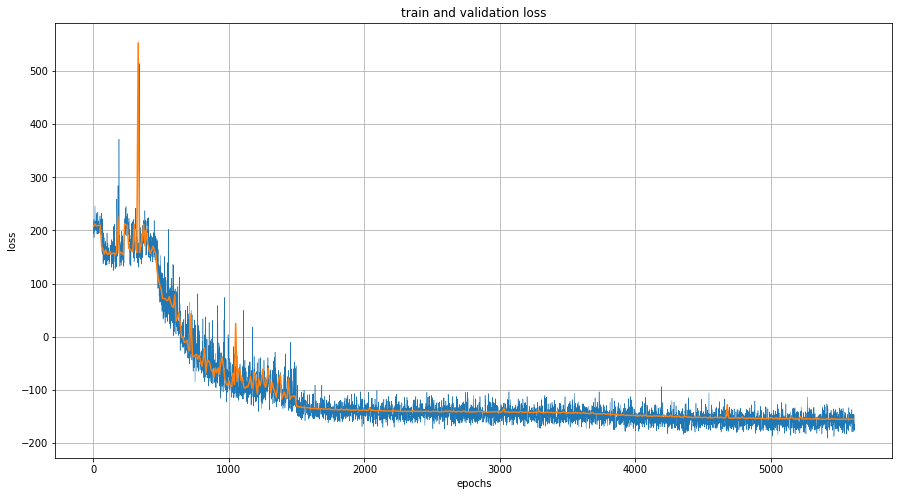

In [26]:
plt.figure(figsize=(15,8))
plt.title("train and validation loss")
epoch_axis = np.arange(len(svi.loss_history["train"]))
plt.plot(epoch_axis, np.array(svi.loss_history["train"]), lw=0.5) #np.arange(len(svi.loss_history["validation"]))*10
plt.plot(np.arange(len(svi.loss_history["validation"]))*10, svi.loss_history["validation"])
#plt.ylim((-150, 500))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
#torch.save(svi.model, "LSTM_remake_1000ep.pt")
#torch.save(svi.model.state_dict(), "LSTM_remake_1000ep_state_dict.pt")

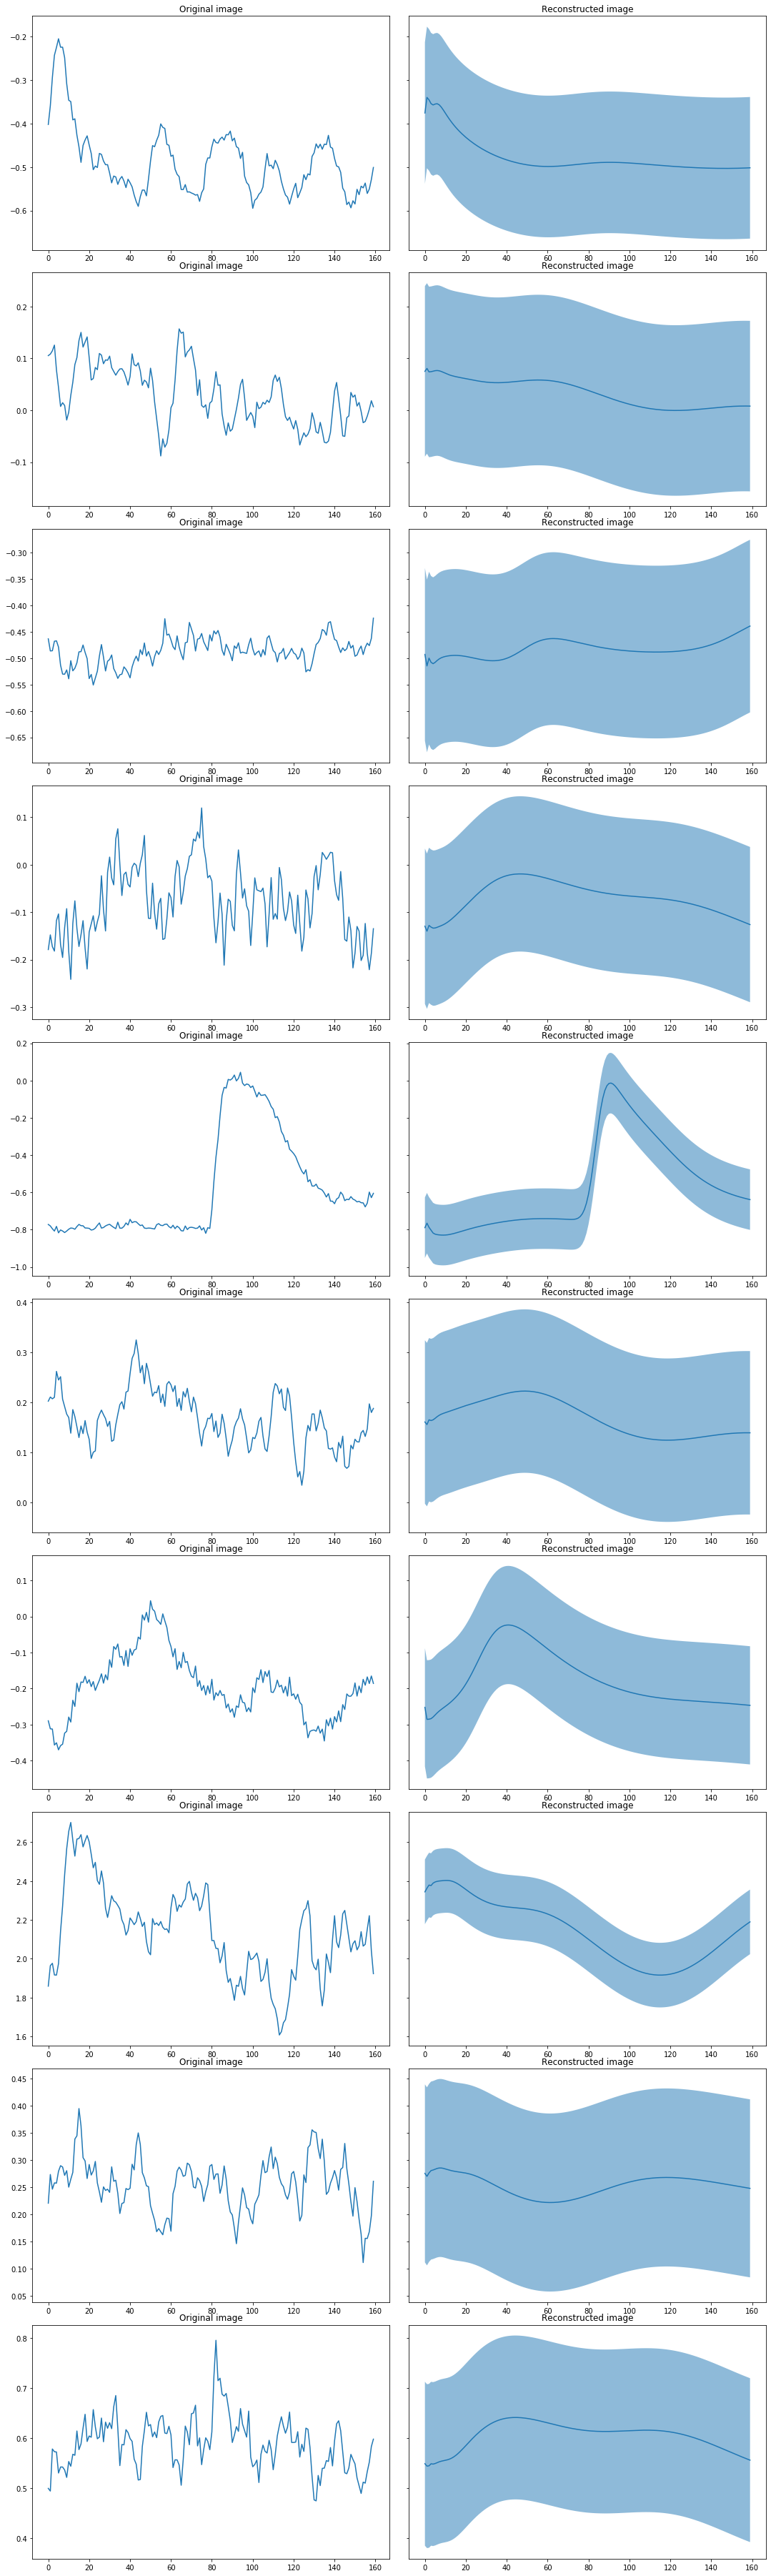

In [27]:

X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.cuda())
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50), sharey="row")
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

In [31]:
#torch.save(svi.model, "models_and_losses/LSTM_remakeII_500ep.pt")
torch.save(svi.model.state_dict(), "models_and_losses/LSTM_remakeII_500ep_state_dict.pt")

In [33]:
svi.model

LSTM_VAE(
  (encoder): LSTM_Encoder(
    (encoder_reshape): Reshape()
    (encoder_lstm): LSTM(1, 128)
    (encoder_output): VariationalLayer(
      (mu): Linear(in_features=256, out_features=15, bias=True)
      (rho): Linear(in_features=256, out_features=15, bias=True)
      (softplus): Softplus(beta=1, threshold=20)
    )
  )
  (decoder): LSTM_Decoder(
    (decoder_hidden): Linear(in_features=15, out_features=256, bias=True)
    (decoder_lstm): LSTM(1, 128)
    (decoder_output): RecurrentDecoderOutput(
      (mu): Linear(in_features=128, out_features=1, bias=True)
      (rho): Linear(in_features=20480, out_features=1, bias=True)
      (softplus): Softplus(beta=1, threshold=20)
    )
  )
)

In [39]:
train.X[:35000,:].shape

torch.Size([35000, 160])

In [ ]:
_, X_encoder_1,_ = svi.model.encoder(train.X[:35000,:].cuda())
_, X_encoder_2,_ = svi.model.encoder(train.X[35000:,:].cuda())

In [59]:
X_encoder_1 = X_encoder_1[1].cpu().detach()

In [60]:
X_encoder_2 = X_encoder_2[1].cpu().detach()

In [61]:
torch.save(torch.cat((X_encoder_1, X_encoder_2), axis=0), "data/latent_code_train_LSTM_VAE_remake_II.pt")

In [56]:
test.X.shape

torch.Size([16736, 160])

In [62]:
X_t_1 = svi.model.encoder(test.X[:8000,:].cuda())
X_t_2 = svi.model.encoder(test.X[:8000,:].cuda())

In [63]:
X_t_1 = X_t_1[1].cpu().detach()
X_t_2 = X_t_2[1].cpu().detach()

In [64]:
torch.save(torch.cat((X_t_1, X_t_2), axis=0), "data/latent_code_test_LSTM_VAE_remake_II.pt")

In [66]:
np.save("data/latent_code_test_LSTM_VAE_remake_II.npy", torch.cat((X_t_1, X_t_2), axis=0).numpy())
np.save("data/latent_code_train_LSTM_VAE_remake_II.npy", torch.cat((X_encoder_1, X_encoder_2), axis=0).numpy() )

In [69]:
vae2 = LSTM_VAE(sequence_len=160, n_features=1, latent_dim=15, hidden_size=128, num_layer=1, use_cuda=True)

In [70]:
vas2.load_state_dict(torch.load("models_and_losses/LSTM_remakeII_500ep_state_dict.pt"))

NameError: name 'vas2' is not defined